# Imaginary time evolution

Lets focus on 1d for simplicity.
Time evolution is governed by Schrödinger's equation:
$$
i\hbar\frac{\partial\psi(x,t)}{\partial t}=\hat{H}\psi(x,t)
$$

When the Hamiltonian is time independent, it is "straight-forward" to solve the above equation to find the time dependence of $\psi(x,t)$.
What you need to do is first solve the eigenvalue equation for the Hamiltonian:
$$
\hat{H}\psi_n(x)=E_n\psi_n(x),
$$
where $\psi_n(x)$ are the eigenstates and $E_n$ the energy eigenvalues. Second, you need to expand the wave function at an initial time (say $t=0$) in terms of the energy eigenstates:
$$
\psi(x,0)=\sum_nc_n(0)\psi_n(x),
$$
where $c_n(0)$ are the expansion coefficients that you can find by calculating the overlap between $\psi(x,0)$ and the energy basis eigenstates.
Third, the wave function at a later time $t$ is given by:
$$
\psi(x,t)=\sum_nc_n(0)e^{-iE_nt/\hbar}\psi_n(x).
$$
The time dependence is such that each energy eigenstate $\psi_n(x)$ "oscillates" at a frequency proportional to the corresponding energy eigenvalue $E_n/\hbar$.



We now focus on imaginary time evolution. Let's consider a change of variables $\tau=it$. You can think of $\tau$ as "imaginary time". Applying this change of variables to the Schrödinger equation we obtain:
$$
-\hbar\frac{\partial\psi(x,\tau)}{\partial\tau}=\hat{H}\psi(x,\tau).
$$
Again, as $\hat{H}$ is time independent, the dependence on $\tau$ can be solved in the same way in which the dependence on $t$ was solved above, and we obtain:
$$
\psi(x,\tau)=\sum_nc_n(0)e^{-E_n\tau/\hbar}\psi_n(x).
$$
You can now see that the function $\psi(x,\tau)$ at imaginary time $\tau$ is no longer obtained by an "oscillating" superposition of energy eigenstates, but instead by an "exponentially decaying" superposition of energy eigenstates. Furthermore, the exponential decay rate is proportional to $E_n/\hbar$.

What have we accomplished by making this variable change from $t$ to $\tau$? Consider the limit of large $\tau$:
$$
\psi(x,\tau\gg1)\simeq c_0(0)e^{-E_0\tau}\psi_0(x).
$$
In this limit, the ground state $n=0$ is "projected out" of the initial state, because the corresponding exponential decay is the slowest one. Therefore, by evolving the system in "imaginary time", we can obtain the ground state of the Hamiltonian $\psi_0(x)$ as the long imaginary time limit.

Will this always work? This will only work if when you expand the initial state in terms of energy eigenstates, there is some contribution by the ground state. If not, the long imaginary time evolution will instead lead to the lowest energy state present in the initial expansion.

Thanks [stack exchange](https://physics.stackexchange.com/questions/557225/why-do-we-use-the-imaginary-time-evolution-in-simulations-of-some-quantum-system).

In [1]:
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from matplotlib import animation

## Eigenstates of the Harmonic oscillator

$$
|\psi_n(x)\rangle = \frac{1}{\pi 2^nn!} e^{-\frac{(x-x_0)^2}{2}} H_n\left(x-x_0 \right)
$$

where $H_n\left(x \right)$ are the Hermite polynomials of order $n$

NOTE: These are the eigenstates of the following Hamiltonian

$$
H=\frac{p^{2}}{2}+ \frac{1}{2}(x-x_{0})^{2}
$$

Any translation of $|\psi_n(x)\rangle \longrightarrow |\psi_n(x+\delta x)\rangle$ results in a state which is NO MORE an eigenstate of the original Hamiltonian.
We could then decompose $|\psi_n(x+\delta x)\rangle = \sum_{m}C_{m}|\psi_n(x)\rangle$ from some coefficients $C_{m}$ associated to the old eigenstates.

In [2]:
def hermite(x, n):
    """
    hermite polynomials of order n
    defined on the real space x

    Parameters
    ----------
    x : np.ndarray
        Real space
    n : int
        order of the polynomial

    Returns
    -------
    np.ndarray
        Hermite polynomial of order n
    """
    herm_coeffs = np.zeros(n+1)
    herm_coeffs[n] = 1
    return np.polynomial.hermite.hermval(x, herm_coeffs)

def stationary_state(x,n):
    """
    Returns the stationary state of order
    n of the quantum harmonic oscillator

    Parameters
    ----------
    x : np.ndarray
        Real space
    n : int
        order of the stationary state. 0 is ground state.

    Returns
    -------
    np.ndarray
        Stationary state of order n
    """
    prefactor = 1./np.sqrt(2.**n * factorial(n)) * (1/(np.pi))**(0.25)
    psi = prefactor * np.exp(- x**2 / 2) * hermite(x,n)
    return psi

## Initialization for the simulation

Initialize correctly the real space and the momentum grid.
Be careful about the initialization of the momentum, how it should be treated.
Have a look at the `np.fft.fft` documentation.

<details>
  <summary>Solution part 1</summary>

```python
self.x = np.arange(-xmax + xmax / num_x, xmax, self.dx)
...
self.k = np.concatenate((np.arange(0, num_x / 2),
                                 np.arange(-num_x / 2, 0))) * self.dk
```
</details>

In [3]:
class Param:
    """
    Container for holding all simulation parameters

    Parameters
    ----------
    xmax : float
        The real space is between [-xmax, xmax]
    num_x : int
        Number of intervals in [-xmax, xmax]
    dt : float
        Time discretization
    timesteps : int
        Number of timestep
    im_time : bool, optional
        If True, use imaginary time evolution.
        Default to False.
    """
    def __init__(self,
                 xmax: float,
                 num_x: int,
                 dt: float,
                 timesteps: int,
                 im_time: bool = False) -> None:

        self.xmax = xmax
        self.num_x = num_x
        self.dt = dt
        self.timesteps = timesteps
        self.im_time = im_time

        self.dx = 2 * xmax / num_x
        # Real time grid
        self.x = np.arange(-xmax + xmax / num_x, xmax, self.dx)
        # Definition of the momentum
        self.dk = np.pi / xmax
        # Momentum grid
        self.k = np.concatenate((np.arange(0, num_x / 2), np.arange(-num_x / 2, 0))) * self.dk


class Operators:
    """Container for holding operators and wavefunction coefficients."""
    def __init__(self, res: int) -> None:

        self.V = np.empty(res, dtype=complex)
        self.R = np.empty(res, dtype=complex)
        self.K = np.empty(res, dtype=complex)
        self.wfc = np.empty(res, dtype=complex)

## Set the evolution operators for the imaginary time

Set the coefficiant `coeff` such that it enables real or
imaginary time evolution

<details>
  <summary>Solution part 2</summary>

```python
1 if par.im_time else 1j
```
</details>

In [4]:
def init(par: Param, voffset: float, wfcoffset: float, n:int = 0) -> Operators:
    """
    Initialize the wavefunction coefficients and the potential.

    Parameters
    ----------
    par: Param
        Class containing the parameters of the simulation
    voffset : float, optional
        Offset of the quadratic potential in real space
        Default to 0.
    wfcoffset: float, optional
        Offset of the wavefunction in real space. Default to 0.
    n : int, optional
        Order of the hermite polynomial (i.e. level of eigenstate)

    Returns
    -------
    Operators
        Filled operators
    """
    opr = Operators(len(par.x))

    # Quadratic potential
    opr.V = 0.5 * (par.x - voffset) ** 2
    opr.wfc = stationary_state(par.x-wfcoffset, n).astype(complex)

    # Complete here to implement imaginary time evolution based on par.im_time
    coeff = 1 if par.im_time else 1j
    # CREATE THE EXPONENTIAL PART OF THE HAMILTONIAN (we exploit the Hausdorff expansion of the matrix exponential e^{A+B}\sim e^{A}e^{B}+ o(dt^{2}))
    # Operator in momentum space
    opr.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    # Operator in real space
    opr.R = np.exp(-0.5 * opr.V * par.dt * coeff)

    return opr


## Time evolution

Complete the split operator method filling the part for imaginary time evolution.
The wavefunction should be normalized at any time!

<details>
  <summary>Solution part 3</summary>

```python
renorm_factor = np.sum( density * par.dx )
opr.wfc /= np.sqrt(renorm_factor)
```
</details>

In [5]:
def split_op(par: Param, opr: Operators) -> None:
    """
    Split operator method for time evolution.
    Works in place

    Parameters
    ----------
    par : Param
        Parameters of the simulation
    opr : Operators
        Operators of the simulation

    Returns
    -------
    None
        Acts in place
    """
    # Store the results in res.
    # Use the first 100 to store the wfc in real
    # space and the other half to store the wavefunction
    # in momentum space
    # Initialize res to store real and momentum space densities separately
    res = np.zeros((2, par.timesteps, par.num_x))
    for i in range(par.timesteps):

        # Half-step in real space
        opr.wfc *= opr.R

        # FFT to momentum space
        opr.wfc = np.fft.fft(opr.wfc)

        # Full step in momentum space
        opr.wfc *= opr.K

        # iFFT back
        opr.wfc = np.fft.ifft(opr.wfc)

        # Final half-step in real space
        opr.wfc *= opr.R

        # Density for plotting and potential
        density = np.abs(opr.wfc) ** 2
        density_momentum = np.abs(np.fft.fft(opr.wfc))**2

        # Renormalizing for imaginary time
        if par.im_time:
            # Compute the renormalization factor
            renorm_factor = np.sum( density * par.dx )
            # Renormalize the wavefunction opr.wfc
            opr.wfc /= np.sqrt(renorm_factor)

        # Save to res
        res[0, i, :] = np.real(density)  # Real space
        res[1, i, :] = np.real(density_momentum)  # Momentum space

    return res

In [6]:
def calculate_energy(par: Param, opr: Operators) -> float:
    """Calculate the energy <Psi|H|Psi>."""
    # Creating real, momentum, and conjugate wavefunctions.
    wfc_r = opr.wfc
    wfc_k = np.fft.fft(wfc_r)
    wfc_c = np.conj(wfc_r)

    # Finding the momentum and real-space energy terms
    energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
    energy_r = wfc_c * opr.V * wfc_r

    # Integrating over all space
    energy_final = sum(energy_k + energy_r).real

    return energy_final * par.dx

## Time to play around!

Try the algorithm and see if it gives the correct energy/eigenstate!
We can also look at the time evolution in real space, and visualize it with the gifs.

You can also pass some random wfc to the algorithm to see how the imaginary time evolution performs.

In [7]:
nx = 1000

voffset=0
wfcoffset=1
n=1

params = Param(xmax=4, num_x=nx, dt=0.025, timesteps=20000, im_time=True)
ops = init(params, voffset, wfcoffset, n)


custom_wfc = np.zeros(nx, dtype=complex)
for n in range(10):
    custom_wfc += stationary_state(params.x-wfcoffset, n).astype(complex)
from numpy.linalg import norm
print(norm(custom_wfc))

if custom_wfc is not None:
    # First ensure it is normalized
    custom_wfc /= norm(custom_wfc)
    ops.wfc = custom_wfc
    print(norm(custom_wfc))
    

23.788044154639095
0.9999999999999999


In [8]:
res = split_op(params, ops)

print(f"The final energy of your systems is: {calculate_energy(params, ops)}")

The final energy of your systems is: 0.4999994753031784


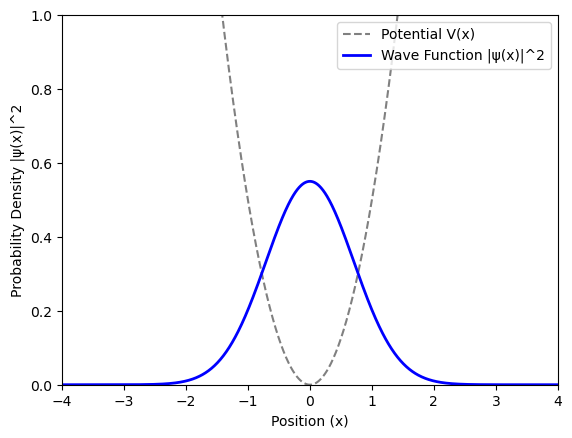

In [9]:
# Set up the figure and axis for the animation
step_interval = max(params.timesteps // 500, 1)  # Ensure at least 200 frames, adjust as needed
selected_frames = range(0, params.timesteps, step_interval)

fig, ax = plt.subplots()
ax.set_xlim(-params.xmax, params.xmax)
ax.set_ylim(0, 1)
ax.set_xlabel("Position (x)")
ax.set_ylabel("Probability Density |ψ(x)|^2")

# Plot the potential and prepare the line for the wave function
ax.plot(params.x, ops.V, label="Potential V(x)", color='gray', linestyle='--')
line, = ax.plot([], [], lw=2, label="Wave Function |ψ(x)|^2", color='blue')
ax.legend()

# Initialization function for the animation
def init_line():
    line.set_data([], [])
    return line,

# Animation function that updates the plot at each frame
def animate(i):
    x = params.x
    y = res[0, i, :]
    
    line.set_data(x, y)
    return line,

# Create the animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init_line, frames=selected_frames, interval=40, blit=True
)

# Save the animation as a GIF
writer = animation.PillowWriter(fps=1, metadata=dict(artist='Me'), bitrate=1800)
anim.save('real_space.gif', writer=writer)

plt.show()

In [ ]:
# Set up the figure and axis for the momentum space animation
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)  # Set the x-axis limit for momentum space
#ax.set_ylim(0,1)  # Dynamically set y-axis limit based on res values
ax.set_xlabel("Momentum (k)")
ax.set_ylabel("Amplitude |ψ(k)|^2")

# Initialize the line for momentum space
line, = ax.plot([], [], lw=2, label="Wave Function |ψ(k)|^2", color='blue')
ax.legend()

# Initialization function for the animation (clears the line)
def init_line():
    line.set_data([], [])
    return line,

# Animation function that updates the plot at each frame
def animate(i):
    x = params.k
    y = res[1,i, :]  # Extract momentum space density from res for frame i
    integral = np.trapz(y, x)  # Calculate the integral of y with respect to x
    if integral > 0:
        y = y / integral  # Normalize so that the area under the curve is 1
    order = np.argsort(x)  # Sort x for proper plotting
    x = x[order]
    y = y[order]
    line.set_data(x, y)
    return line,

# Create the animation for momentum space
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init_line,
    frames=params.timesteps,      # Number of frames for the animation
    interval=20,     # Time between frames in milliseconds
    blit=True
)

# Save the animation as a GIF
writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('momentum_space.gif', writer=writer)

plt.show()